In [1]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.embedders import SentenceTransformersDocumentEmbedder, SentenceTransformersTextEmbedder
from haystack.components.generators import OpenAIGenerator
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.document_stores.types import DuplicatePolicy

# Indexing
document_store = InMemoryDocumentStore()
document_writer = DocumentWriter(document_store, policy=DuplicatePolicy.OVERWRITE)
doc_embedder = SentenceTransformersDocumentEmbedder(
    model="sentence-transformers/all-MiniLM-L6-v2", batch_size=16
)  # "sentence-transformers/all-MiniLM-L12-v2"

indexing_pipeline = Pipeline()
indexing_pipeline.add_component("document_writer", document_writer)
indexing_pipeline.add_component("doc_embedder", doc_embedder)
indexing_pipeline.connect("doc_embedder", "document_writer")

# Retrieval + Generation
text_embedder = SentenceTransformersTextEmbedder(model="sentence-transformers/all-MiniLM-L6-v2")
retriever = InMemoryEmbeddingRetriever(document_store, top_k=10)

generator = OpenAIGenerator(
    model="gpt-4o-mini",
    generation_kwargs={"temperature": 0},
)

template = """
Given the following information, answer the question.

Context:
{% for document in documents %}
    {{ document.content }}
{% endfor %}

Question: {{question}}
Answer:
"""

prompt_builder = PromptBuilder(template=template)

rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", generator)

rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("retriever", "prompt_builder.documents")
rag_pipeline.connect("prompt_builder", "llm")

🚅 Components
  - text_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - text_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

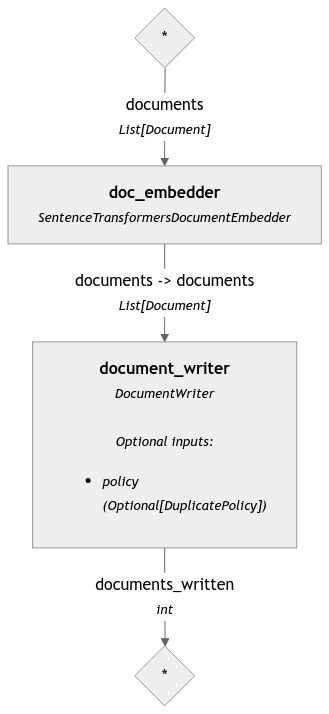

In [ ]:
indexing_pipeline.show()

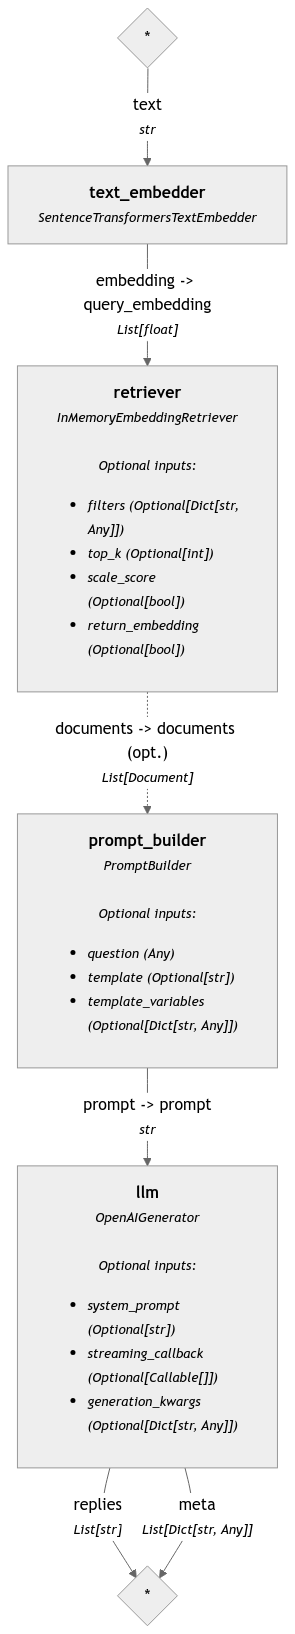

In [3]:
rag_pipeline.show()

## Indexing

In [5]:
from datasets import load_dataset
from haystack import Document

dataset = load_dataset("bilgeyucel/seven-wonders", split="train")
docs = [Document(content=doc["content"], meta=doc["meta"]) for doc in dataset][:10]
indexing_pipeline.warm_up()

indexing_pipeline.run({"doc_embedder": {"documents": docs}})

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

{'document_writer': {'documents_written': 10}}

## Response

In [6]:
question = "What does Rhodes Statue look like?"

response = rag_pipeline.run({"text_embedder": {"text": question}, "prompt_builder": {"question": question}})

print(response["llm"]["replies"][0])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

The Colossus of Rhodes was a massive statue of the Greek sun-god Helios, standing approximately 70 cubits (about 33 meters or 108 feet) tall. It was constructed with iron tie bars and brass plates that formed its skin, while the interior was filled with stone blocks. The statue was depicted as a muscular figure, symbolizing strength and freedom, and was designed to celebrate the successful defense of Rhodes against an attack.

The statue was erected on a 15-meter-high (49-foot) white marble pedestal, which was either circular or octagonal in shape. The feet of the statue were carved from stone and covered with thin bronze plates. The design included eight forged iron bars that formed the ankles and legs, with individually cast bronze plates making up the body. The Colossus was noted for its impressive scale, with fingers larger than most statues, and its remains, even after its collapse, were described as awe-inspiring.

Overall, the Colossus of Rhodes was not only a remarkable enginee